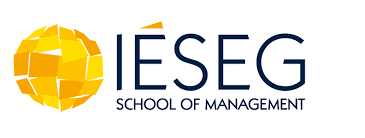

<font size="5.5">**1. Project Definition**</font>

<div style="text-align: justify"> DSC is an organization that helps non-profit organizations to find donors
for their good causes.They have a huge database with candidate donors.
DSC now wants to launch a new re-activation campaign where they want to send
letters to donors that have been inactive for a long time,hoping that they 
will donate again. The CEO & Head of Data Analytics (conveniently, this is the
same person for this exercise) have to be convinced that your model is
better than just randomly selecting donors.

DSC is mostly interested in customers that have donated €30 or more, but you can be
flexible in this decision, depending on your business case </div>

For this project we have 3 main datasets: 
<br>
>**1. Gifts**: Contains a complete history of all donations made over a
20 year period
<br>
>**2. Donors**:Contains socio-demographic information on all donors that
made at least one donation via DSC
<br>
>**3. Campaigns**:Contains details of all campaigns launched by DSC since
2004.
*

For this project our objecticve is to build a predictive model to select the best candidates for a fundraising campaign ( using as example campaigns No. 6169 ( Launched on 04/09/2018 )and 7244 (Launched on 18/06/2019). 

**We must create a model that is more efficient than a random selection**


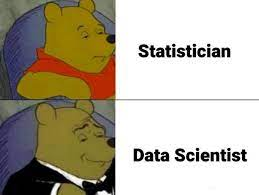

<font size="5.5">**2. Data Preparation**</font>

**LIBRARIES**

In [1]:
import pandas as pd
import import_ipynb
import seaborn as sns
from collections import Counter
from functions import my_mode
import random
import numpy as np

importing Jupyter notebook from functions.ipynb


**2.1 Cleaning `campaigns`table**

In [2]:
#Reading data from the campaigns dataset.
campaigns = pd.read_csv('../data/campaigns.csv', sep=';')
print(campaigns.info())
campaigns.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 367 entries, 0 to 366
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   campaignID   367 non-null    int64 
 1   date         367 non-null    object
 2   lettersSent  367 non-null    object
 3   CostUnit     367 non-null    object
dtypes: int64(1), object(3)
memory usage: 11.6+ KB
None


,campaignID,date,lettersSent,CostUnit
0,153,13/12/2004,6 873,"0,17 €"
1,154,01/01/2005,7 656,"0,30 €"
2,180,18/01/2005,9 933,"0,20 €"
3,433,29/01/2005,7 448,"0,59 €"
4,476,12/02/2005,6 605,"0,51 €"


In [3]:
#Convert date into a datetime format
campaigns['date']= pd.to_datetime(campaigns['date'], infer_datetime_format=True)

#convert lettersSent column into an integer type
campaigns['lettersSent']=campaigns['lettersSent'].str.replace('\u202f', '').astype(int)

#convert CostUnit into a float type
campaigns['CostUnit'] = campaigns['CostUnit'].str.replace('\xa0€', '').str.replace(',', '.').astype(float)


print(campaigns.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 367 entries, 0 to 366
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   campaignID   367 non-null    int64         
 1   date         367 non-null    datetime64[ns]
 2   lettersSent  367 non-null    int32         
 3   CostUnit     367 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int32(1), int64(1)
memory usage: 10.2 KB
None


In [17]:
campaigns.to_csv("../Data/Processed/campaigns_cleaned.csv", index=False)

**2.2 Cleaning `donors` table**

In [49]:
#Reading data from the donors dataset.
donors = pd.read_csv('../Data/Raw/donors.csv').drop('Unnamed: 0',axis=1)
print(donors.info())
donors.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44691 entries, 0 to 44690
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   donorID      44691 non-null  int64  
 1   zipcode      44689 non-null  float64
 2   province     44691 non-null  object 
 3   region       44691 non-null  object 
 4   gender       44659 non-null  object 
 5   language     44691 non-null  object 
 6   dateOfBirth  44691 non-null  object 
dtypes: float64(1), int64(1), object(5)
memory usage: 2.4+ MB
None


,donorID,zipcode,province,region,gender,language,dateOfBirth
0,100001,1861.0,Flemish Brabant,Flanders,F,NL,12/24/1967
1,100002,2260.0,Antwerp,Flanders,M,NL,01/14/1952
2,100003,1780.0,Flemish Brabant,Flanders,M,NL,12/23/1986
3,100004,1020.0,Brussels,Brussels,F,FR,03/29/1952
4,100005,1020.0,Brussels,Brussels,F,FR,06/25/1986


In [52]:
donors[donors['donorID']==265584]

,donorID,zipcode,province,region,gender,language,dateOfBirth


In [42]:
donors[donors['donorID']==111592]

,donorID,zipcode,province,region,gender,language,dateOfBirth
11591,111592,1050.0,Brussels,Brussels,M,FR,10/16/1970


In [47]:
#checking for the mode of zipcodes ( most repeated value)
donors[donors['zipcode'] == my_mode(donors['zipcode'])[0]]

#replace Na's in zipcode with mode
donors['zipcode'] = donors['zipcode'].fillna(my_mode(donors['zipcode'])[0])

donors['zipcode'] = donors['zipcode'].astype(int)


#Filling NAs of Gender column with F and M
print("The percentages are very close, best to use a randomizer to fill na's: ",donors['gender'].value_counts(normalize = True))

donors['gender'] = donors['gender'].fillna(random.choice(['F', 'M']))

#Convert date into a datetime format
donors['dateOfBirth']= pd.to_datetime(donors['dateOfBirth'], infer_datetime_format=True)



##ADDING NEW DATA

#Income table by region. Retrieved from: https://statbel.fgov.be/en/open-data/fiscal-statistics-income
zip_income_BEL = pd.read_excel('../Data/Raw/TF_PSNL_INC_TAX_MUNTY.xlsx')
zip_income_BEL = zip_income_BEL[zip_income_BEL['CD_YEAR'] == 2018]

#Table connecting zipcode and REFNIS code
REFNIS= pd.read_excel('../Data/Raw/Conversion Postal code_Refnis code_va01012019.xlsx')

#Merge to obtain the income by zip code.
income = pd.merge(zip_income_BEL[['CD_MUNTY_REFNIS', 'MS_TOT_NET_INC','MS_TOT_RESIDENTS']]
                  , REFNIS, how = 'left', left_on = 'CD_MUNTY_REFNIS', right_on = 'Refnis code')


#Merge with original donors table.
donors = pd.merge(donors, income, how = 'left', left_on = 'zipcode', right_on = 'Postal code')

#Keep relevant columns
donors=donors[['donorID', 'zipcode', 'gender', 'language', 'dateOfBirth', 'MS_TOT_NET_INC','MS_TOT_RESIDENTS']]


donors['avg. income'] = donors['MS_TOT_NET_INC']/donors['MS_TOT_RESIDENTS']

The percentages are very close, best to use a randomizer to fill na's:  M    0.57751
F    0.42249
Name: gender, dtype: float64


<AxesSubplot:xlabel='avg. income', ylabel='Count'>

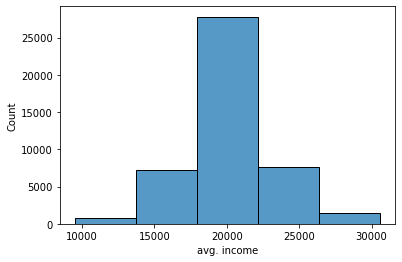

In [32]:
sns.histplot(data = donors, x = 'avg. income', bins = 5)

In [33]:
#Creating the conditionals for income ranges. 
donors['income range']= np.where(donors['avg. income']< 5000, 'Less than 5.000',
                                np.where((donors['avg. income']>= 5000) & (donors['avg. income']< 10000), '[5k, 10k)',
                                        np.where((donors['avg. income']>= 10000) & (donors['avg. income']< 15000), '[10k, 15k)',
                                                np.where((donors['avg. income']>= 15000) & (donors['avg. income']< 20000), '[15k, 20k)',
                                                        np.where((donors['avg. income']>= 20000) & (donors['avg. income']< 25000), '[20k, 25k)',
                                                                np.where((donors['avg. income']>= 25000) & (donors['avg. income']< 30000), '[25k, 30k)',
                                                                         '>= 30k'))))))

#Drop not important columns, after data manipulation
donors = donors.drop(['MS_TOT_NET_INC', 'MS_TOT_RESIDENTS', 'avg. income'], axis=1)

#creating dummies for modelling
donors = donors.join(pd.get_dummies(donors["gender"], drop_first = True)).rename(columns={'M':'Gender'})

#Drop not important columns, after data manipulation
donors = donors.drop('gender', axis=1)

#creating dummies for modelling
donors = donors.join(pd.get_dummies(donors["language"], prefix='Language is_', drop_first = True))

#Drop not important columns, after data manipulation
donors = donors.drop('language',axis=1)

#creating dummies for modelling
donors = donors.join(pd.get_dummies(donors["income range"], prefix='Income range is_', drop_first = True))

#Drop not important columns, after data manipulation
donors=donors = donors.drop('income range',axis=1)



donors.head()

,donorID,zipcode,dateOfBirth,Gender,Language is__FR,Language is__NL,Income range is__>= 30k,"Income range is__[10k, 15k)","Income range is__[15k, 20k)","Income range is__[20k, 25k)","Income range is__[25k, 30k)"
0,100001,1861,1967-12-24,0,0,1,0,0,0,1,0
1,100002,2260,1952-01-14,1,0,1,0,0,0,1,0
2,100003,1780,1986-12-23,1,0,1,0,0,0,1,0
3,100004,1020,1952-03-29,0,1,0,0,1,0,0,0
4,100005,1020,1986-06-25,0,1,0,0,1,0,0,0


In [55]:
donors['dateOfBirth']=pd.to_datetime(donors['dateOfBirth'])

In [58]:
donors['dateOfBirth'].sort_values()

27008   1889-06-14
27453   1892-08-06
27299   1919-08-26
18762   1919-09-02
26716   1919-10-02
           ...    
2654    1995-04-09
26350   1995-04-09
40737   1995-04-09
18210   1995-04-09
39096   1998-06-12
Name: dateOfBirth, Length: 44691, dtype: datetime64[ns]

In [18]:
donors.to_csv("../Data/Processed/donors_cleaned.csv", index=False)

**2.3 Cleaning `gifts` table**

In [22]:
#Reading data from the gifts dataset.
gifts = pd.read_csv('../Data/Raw/gifts.csv').drop('Unnamed: 0',axis=1)
print(gifts.info())
gifts.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216594 entries, 0 to 216593
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   donorID     216594 non-null  int64  
 1   campaignID  200957 non-null  float64
 2   amount      216594 non-null  object 
 3   date        216594 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 6.6+ MB
None


,donorID,campaignID,amount,date
0,100001,NaN,"12,39",2004-03-23
1,100001,1577.0,"12,39",2007-10-11
2,100001,1634.0,"6,69",2007-12-28
3,100001,1778.0,"24,79",2008-06-14
4,100001,1808.0,"7,44",2008-07-09


In [23]:
#Converting to float
gifts['amount'] = gifts['amount'].str.replace(',', '.').astype(float)

#Convert date into a datetime format
gifts['date']= pd.to_datetime(gifts['date'], infer_datetime_format=True)

In [24]:
gifts.to_csv("../Data/Processed/gifts_cleaned.csv", index=False)

In [16]:
#reading participants of both campaigns
camp6169 = pd.read_csv('../data/camp6169.csv')
camp7274= pd.read_csv('../data/camp7274.csv')
#amount of participants
print("Participants for campaign 6169: ", camp6169.shape[0], "Participants for campaign 7274: ", camp7274.shape[0])

Participants for campaign 6169:  34888 Participants for campaign 7274:  25645
